In [88]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
from math import*
import csv

import plotly as py
import plotly.graph_objs as go
#from plotly.tools import figure_factory
import numpy as np

import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV


from subprocess import call




# connect to MongoDB, change the << MONGODB URL >> to reflect your own connection string
client = MongoClient("localhost:27017")
db=client.COCONUTapril
# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")


#pprint(serverStatusResult)


from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw

from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs


In [152]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [153]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [154]:
collection = db.uniqueNaturalProduct.find({"$and": [{"textTaxa":"bacteria"}, {"textTaxa": {"$size":1}}]})
bacteria = pd.DataFrame(list(collection))
del bacteria['_id']
del bacteria['_class']

collection = db.uniqueNaturalProduct.find({"$and": [{"textTaxa":"plants"}, {"textTaxa": {"$size":1}}]})
plant = pd.DataFrame(list(collection))
del plant['_id']
del plant['_class']

collection = db.uniqueNaturalProduct.find({"$and": [{"textTaxa":"fungi"}, {"textTaxa": {"$size":1}}]})
fungi = pd.DataFrame(list(collection))
del fungi['_id']
del fungi['_class']

collection = db.uniqueNaturalProduct.find({"$and": [{"textTaxa":"marine"}, {"textTaxa": {"$size":1}}]})
marine = pd.DataFrame(list(collection))
del marine['_id']
del marine['_class']

In [155]:
print("number of bacterial NPs: "+str(len(bacteria)))
print("number of plant NPs: "+str(len(plant)))
print("number of fungi NPs: "+str(len(fungi)))
print("number of marine NPs: "+str(len(marine)))

number of bacterial NPs: 1745
number of plant NPs: 72427
number of fungi NPs: 1701
number of marine NPs: 9820


In [156]:
#make subsets of data

#bacteria: no need
bacteria_ids = []
for index, line in bacteria.iterrows():
    bacteria_ids.append(line["coconut_id"])



In [157]:
#marine : extract 600


marine_ids_tmp = []
marine_mols = []
for index, line in marine.iterrows():
    marine_mols.append(Chem.MolFromSmiles(line["smiles"]))
    marine_ids_tmp.append(line["coconut_id"])
    
tmp_ids = marine_ids_tmp[:]
tmp_mols = marine_mols[:]

for i in range(len(marine_mols)-1, -1, -1):
    if marine_mols[i] == None:
        tmp_mols.pop(i)
        tmp_ids.pop(i)
        
marine_mols = tmp_mols 
marine_ids_tmp = tmp_ids    
        
fps = [GetMorganFingerprint(x,3) for x in marine_mols]
nfps = len(fps)

def distij(i,j,fps=fps):
    return 1-DataStructs.DiceSimilarity(fps[i],fps[j])

picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,650,seed=23)

marine_ids = [marine_ids_tmp[x] for x in pickIndices] #only smiles (normally)


In [158]:
# fungi: extract 600
fungi_ids_tmp = []
fungi_mols = []
for index, line in fungi.iterrows():
    fungi_mols.append(Chem.MolFromSmiles(line["smiles"]))
    fungi_ids_tmp.append(line["coconut_id"])
    
tmp_ids = fungi_ids_tmp[:]
tmp_mols = fungi_mols[:]

for i in range(len(fungi_mols)-1, -1, -1):
    if fungi_mols[i] == None:
        tmp_mols.pop(i)
        tmp_ids.pop(i)
        
fungi_mols = tmp_mols 
fungi_ids_tmp = tmp_ids    
        
fps = [GetMorganFingerprint(x,3) for x in fungi_mols]
nfps = len(fps)

def distij(i,j,fps=fps):
    return 1-DataStructs.DiceSimilarity(fps[i],fps[j])

picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,650,seed=23)

fungi_ids = [fungi_ids_tmp[x] for x in pickIndices] #only smiles (normally)


In [159]:
#plant: extract 600

plant_ids_tmp = []
plant_mols = []
for index, line in plant.iterrows():
    plant_mols.append(Chem.MolFromSmiles(line["smiles"]))
    plant_ids_tmp.append(line["coconut_id"])
    
tmp_ids = plant_ids_tmp
tmp_mols = plant_mols


for i in range(len(plant_mols)-1, -1, -1):
    if plant_mols[i] == None:
        tmp_mols.pop(i)
        tmp_ids.pop(i)
        
plant_mols = tmp_mols 
plant_ids_tmp = tmp_ids    
        
fps = [GetMorganFingerprint(x,3) for x in plant_mols]
nfps = len(fps)

def distij(i,j,fps=fps):
    return 1-DataStructs.DiceSimilarity(fps[i],fps[j])

picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,650,seed=23)

plant_ids = [plant_ids_tmp[x] for x in pickIndices] #only smiles (normally)


In [160]:
#extract the features : EFG

efg = db.uniqueNaturalProduct.distinct("ertlFunctionalFragments")

efg_set = set()

for item in efg:
    #item is a dic
    for fg in item.keys():
        efg_set.add(fg)

efg_list = list(efg_set)

In [161]:
# create data table with molecular descriptors


columns_list = ["heavy_atom_number", "molecular_weight", "npl_score", "npl_sugar_score", "number_of_carbons", "number_of_nitrogens", "number_of_oxygens", "number_of_rings", "bond_count", "alogp", "amralogp", "apol", "bpol", "eccentricConnectivityIndexDescriptor", "fmfDescriptor", "fsp3", "fragmentComplexityDescriptor", "hybridizationRatioDescriptor", "kappaShapeIndex1", "manholdlogp", "petitjeanNumber", "petitjeanShapeTopo", "lipinskiRuleOf5Failures", "numberSpiroAtoms", "vertexAdjMagnitude", "weinerPathNumber", "weinerPolarityNumber", "xlogp", "zagrebIndex", "topoPSA", "tpsaEfficiency", "isBacteria"]
print(len(columns_list))


indexes_list = marine_ids+bacteria_ids+fungi_ids+plant_ids


all_data = pd.DataFrame(columns=columns_list, index=indexes_list)



32


In [162]:
#marine
for index, line in marine.iterrows():
    if line["coconut_id"] in marine_ids:
        cid= line["coconut_id"]
        features_list = [0] * (len(columns_list)-1)
        for feature in columns_list[:-1]:
            features_list[columns_list.index(feature)] = line[feature]
        
        features_list.append(0)
        all_data.loc[cid] = features_list
            

In [163]:
#bacteria
for index, line in bacteria.iterrows():
    if line["coconut_id"] in bacteria_ids:
        cid= line["coconut_id"]
        features_list = [0] * (len(columns_list)-1)
        for feature in columns_list[:-1]:
            features_list[columns_list.index(feature)] = line[feature]
        
        features_list.append(1)
        all_data.loc[cid] = features_list
            

In [164]:
#fungi
for index, line in fungi.iterrows():
    if line["coconut_id"] in fungi_ids:
        cid= line["coconut_id"]
        features_list = [0] * (len(columns_list)-1)
        for feature in columns_list[:-1]:
            features_list[columns_list.index(feature)] = line[feature]
        
        features_list.append(0)
        all_data.loc[cid] = features_list
            

In [165]:
#plant
for index, line in plant.iterrows():
    if line["coconut_id"] in plant_ids:
        cid= line["coconut_id"]
        features_list = [0] * (len(columns_list)-1)
        for feature in columns_list[:-1]:
            features_list[columns_list.index(feature)] = line[feature]
        
        features_list.append(0)
        all_data.loc[cid] = features_list
            

In [166]:
all_data.to_csv(r'bacteria_trainin_molecular_descriptors_data.csv', index = True)


In [167]:
train_data = all_data.copy()


# Extract the labels
labels = np.array(train_data.pop('isBacteria'))

train_data = train_data.astype(float)
# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(train_data, labels, stratify = labels,
                                                          test_size = 0.3)

In [168]:
#imputation of missing values

train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [169]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [170]:
test.shape


(1109, 31)

In [171]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [172]:
model.fit(train, train_labels)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [173]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 729
Average maximum depth 22


In [174]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.79 Train: 1.0
Precision Baseline: 0.47 Test: 0.8 Train: 1.0
Roc Baseline: 0.5 Test: 0.88 Train: 1.0


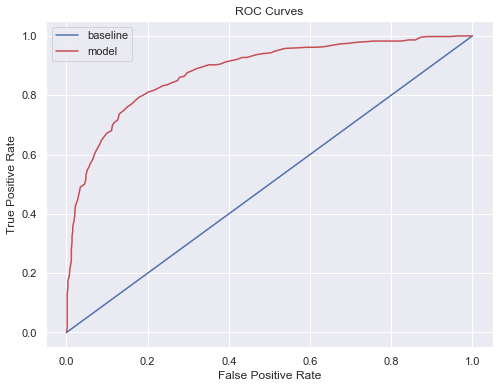

In [175]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


Confusion matrix, without normalization
[[451 134]
 [111 413]]


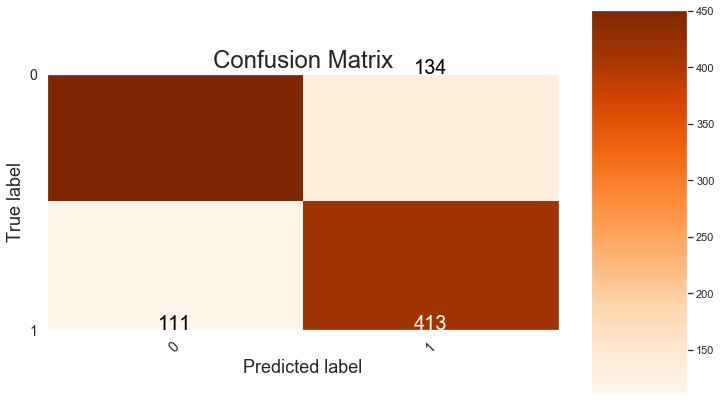

In [185]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ["0", "1"],
                      title = 'Confusion Matrix')

In [177]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)


In [178]:
fi_model.head(10)

,feature,importance
29,topoPSA,0.077184
30,tpsaEfficiency,0.068065
6,number_of_oxygens,0.065221
3,npl_sugar_score,0.048757
27,xlogp,0.046330
2,npl_score,0.042259
25,weinerPathNumber,0.041272
9,alogp,0.039495
13,eccentricConnectivityIndexDescriptor,0.034913
1,molecular_weight,0.034821


In [179]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier()

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 50, verbose = 1)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [180]:
rs.best_params_


{'n_estimators': 168,
 'min_samples_split': 10,
 'max_leaf_nodes': 49,
 'max_features': 0.8999999999999999,
 'max_depth': 15,
 'bootstrap': True}

In [181]:
best_model = rs.best_estimator_

train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [182]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 97
Average maximum depth 12


Recall Baseline: 1.0 Test: 0.79 Train: 0.85
Precision Baseline: 0.47 Test: 0.76 Train: 0.83
Roc Baseline: 0.5 Test: 0.86 Train: 0.93


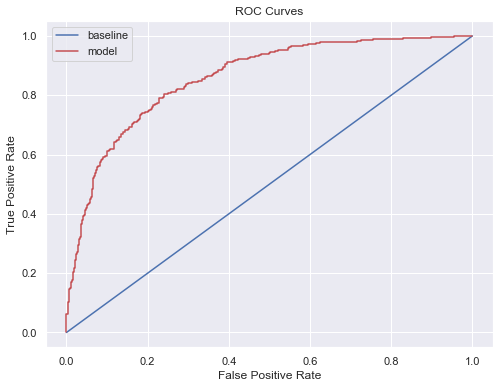

In [183]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


Confusion matrix, without normalization
[[451 134]
 [111 413]]


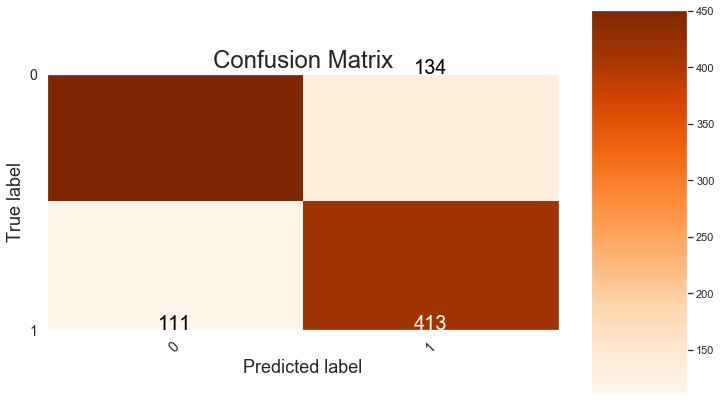

In [186]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ["0", "1"],
                      title = 'Confusion Matrix')